In [ ]:
%load_ext autoreload
%autoreload 2
import os
print(os.getcwd())
to_run = True
if to_run:
    os.chdir('..')
    to_run = False
print(os.getcwd())

/workspaces/REBS/Mandatory Assignment 1/pm4py-dcr-feature-dcr_in_pm4py_revised/notebooks
/workspaces/REBS/Mandatory Assignment 1/pm4py-dcr-feature-dcr_in_pm4py_revised


# Option 1 & 2: example input

Printing the nodes we add to clusters: B

Printing the nodes we add to clusters: N2

Printing the nodes we add to clusters: C

Printing the nodes we add to clusters: D

Printing the nodes we add to clusters: F

Printing the nodes we add to clusters: E



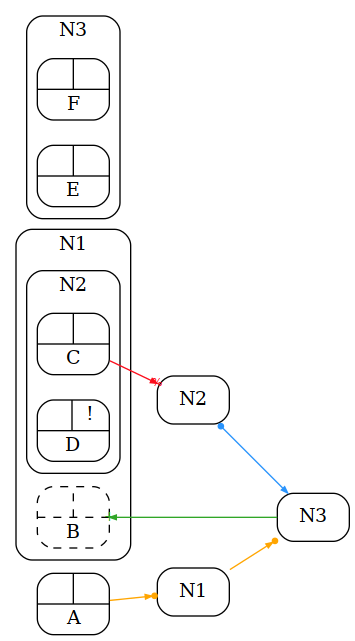

In [2]:
import pandas as pd
import pm4py

from pm4py.objects.dcr.hierarchical.obj import HierarchicalDcrGraph
graph = HierarchicalDcrGraph()

events = [
    "A", "B", "C", "D", "E", "F"
]

groups = [    
    "N1", "N2", "N3"
]

for event in events:
    graph.events.add(event)
    graph.labels.add(event)
    graph.label_map[event] = event
    graph.marking.included.add(event)


for event in groups:
    graph.events.add(event)
    graph.labels.add(event)
    graph.label_map[event] = event
    graph.nestedgroups_map[event] = event

graph.nestedgroups["N1"] =  {"B", "N2"} 
graph.nestedgroups["N2"] =  {"C", "D"} 
graph.nestedgroups["N3"] =  {"E", "F"} 

graph.marking.included.remove("B")
graph.marking.pending.add("D")


graph.conditions["N1"] = {"A"}
graph.conditions["N3"] = {"N1"}

graph.responses["N2"] = {"N3"}

graph.includes["N3"] = {"B"}

graph.excludes["C"] = {"N2"}


#print(graph.nestedgroups["N1"])
#print(graph.conditions)
#for event in graph.nestedgroups:
#    for event_prime in graph.nestedgroups[event]:
#        print(event_prime)
#    print()

pm4py.view_dcr(graph)

# Option 1 example output

In [3]:
import pandas as pd
from io import StringIO
import pm4py
from pm4py.objects.dcr.semantics import DcrSemantics    # Should be HierarchicalDcrSemantics instead!

semantics = DcrSemantics()

errors = 0

expected_enabled = ["A"]
for e in events:
    if e in expected_enabled:
            if not semantics.is_enabled(e, graph):
                errors+=1 #raise Exception("Event should be enabled")
    if not (e in expected_enabled):
        if semantics.is_enabled(e, graph):
                errors+=1 #raise Exception("Event should NOT be enabled")
if semantics.is_accepting(graph):
        errors+=1 #raise Exception("Graph should NOT be accepting")        


semantics.execute(graph, "A")
expected_enabled = ["A", "C", "D"]
for e in events:
    if e in expected_enabled:
            if not semantics.is_enabled(e, graph):
                errors+=1 #raise Exception("Event should be enabled")
    if not (e in expected_enabled):
        if semantics.is_enabled(e, graph):
                errors+=1 #raise Exception("Event should NOT be enabled")
if semantics.is_accepting(graph):
        errors+=1 #raise Exception("Graph should NOT be accepting")                

semantics.execute(graph, "C")
expected_enabled = ["A", "E", "F"]
for e in events:
    if e in expected_enabled:
            if not semantics.is_enabled(e, graph):
                errors+=1 #raise Exception("Event should be enabled")
    if not (e in expected_enabled):
        if semantics.is_enabled(e, graph):
                errors+=1 #raise Exception("Event should NOT be enabled")
if semantics.is_accepting(graph):
        errors+=1 #raise Exception("Graph should NOT be accepting")                

semantics.execute(graph, "B")
expected_enabled = ["A", "B", "E", "F"]
for e in events:
    if e in expected_enabled:
            if not semantics.is_enabled(e, graph):
                errors+=1 #raise Exception("Event should be enabled")
    if not (e in expected_enabled):
        if semantics.is_enabled(e, graph):
                errors+=1 #raise Exception("Event should NOT be enabled")
if semantics.is_accepting(graph):
        errors+=1 #raise Exception("Graph should NOT be accepting")                

semantics.execute(graph, "E")
expected_enabled = ["A", "B", "E", "F"]
for e in events:
    if e in expected_enabled:
            if not semantics.is_enabled(e, graph):
                errors+=1 #raise Exception("Event should be enabled")
    if not (e in expected_enabled):
        if semantics.is_enabled(e, graph):
                errors+=1 #raise Exception("Event should NOT be enabled")
if not semantics.is_accepting(graph):
        errors+=1 #raise Exception("Graph should be accepting")                


errors # This should be 0



15

# Option 2: example output

Note: your visualization doesn't need to match this exactly and it does not need to produce the same layout, but the hiearchical structure should be clearly the same.

![DCR (26).png](<attachment:DCR (26).png>)

# Option 3a details
For option 3 you will need to create a new folder under https://github.com/paul-cvp/pm4py-dcr/tree/feature/dcr_in_pm4py_revised/pm4py/objects/dcr
Here you will add 1) a class defining the object structure for DCR Graphs with multi-instance subprocesses, and 2) a class defining their semantics.
You can take some inspiration from option 1 above on how to structure and test this. 
For defining subprocess templates you likely want to use a structure similar to the HierarchicalDcrGraph class, but keep in mind that there's an important difference between evetns that are part of a sub-process template (which are "abstract"), and real instantiated events. You also want to add the spawn relation.
When implementing the semantics, keep in mind that events are no longer static, but can be spawned. You want to decide on how to name and structure spawned events. For example, you may simply give them a random new name (but keeping the correct label) and treat them as regular events after they have been spawned. Alternatively you could keep track of what subprocess they were spawned under, for example through a naming schema, or through additional data structures. (The latter solution I personally find neater, but it is not strictly required by the formal definitions.)
For testing the semantics, consider using some basic examples, such as:

Example 1:
Graph: Event A spawns a subprocess P, containing an event B that excludes itself.
Expected semantics: any number of As, possibility to execute exactly one B for each A.

Example 2:
Graph: Event A spawns a subprocess P, containing an event B that is initially pending excludes itself.
Expected semantics: any number of As, requirement to execute exactly one B for each A.

Example 3:
Graph: Event A spawns a subprocess P, containing an event B that is initially pending.
Expected semantics: any number of As, requirement to execute at least one B for each A. (Depending somewhat on which Bs are executed, i.e. each spawned B needs to be executed at least once.)

Example 4:
Graph: Event A spawns a subprocess P, containing an event B and C that each exclude themselves. Event B is a condition for C.
Expected semantics: any number of As, for each A it is possible to execute the sequence "B, C" (potentially interupted by others Bs and Cs)

Example 5:
Graph: Event A spawns a subprocess P, containing an event B and C that each exclude themselves. Event B is a condition for C. A excludes itself. Each spawned C includes A.
Expected semantics: The sequence ABC repeated any number of times, without a requirement to finish the final sequence by ending on a C.

Example 6:
Graph: Event A spawns a subprocess P, containing an event B and C that each exclude themselves. Event B is a condition for C. A excludes itself. Each spawned C includes A. C is initially pending.
Expected semantics: The sequence ABC repeated any number of times, once we start a sequence we must finish it.

Example 7:
Graph: Event A spawns a subprocess P, containing an event B and C that each exclude themselves. Event C is initially excluded. Event B includes C. Each spawned C is a condition for A. B and C are pending.
Expected semantics: For each A we see exactly one B and C. Once we see a B, we must see the corresponding C before we can see A again. 
Examples of traces that satisfy this pattern:
ABC
AAABCABCBCBC
AAABBCBCCABC
Examples of traces that do not satisfy this pattern:
A
AB
ABACBC
ABBCACBC





